In [1]:
%load_ext lab_black
%load_ext autoreload
%autoreload 2

import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
from matplotlib.lines import Line2D
from utils import group_boxplot, lighten_boxplot, multi_group_plot_wrapper
import pandas as pd
import numpy as np
import pickle
import statsmodels.api as sm
import calpgs

np.random.seed(42)
plt.rcParams["font.family"] = "Arial"

In [2]:
def plot_r2(df):
    fig, axes = plt.subplots(
        figsize=(7, 1.5),
        dpi=150,
        ncols=4,
        sharey=True,
        gridspec_kw={"width_ratios": [1, 2, 1.5, 2]},
    )

    dict_cov_label = {
        "marginal": "Overall",
        "AGE_q": "Age quintile",
        "PC1_q": "PC1 quintile",
        "SEX_q": "Sex",
    }

    for i, cov in enumerate(
        [
            "marginal",
            "AGE_q",
            "SEX_q",
            "PC1_q",
        ]
    ):
        r2 = df[df["col"].str.startswith(cov)].groupby("col").mean()["r2"].values
        r2_se = df[df["col"].str.startswith(cov)].groupby("col").sem()["r2"].values
        axes[i].bar(
            x=np.arange(len(r2)),
            height=r2,
            yerr=r2_se * 2,
            edgecolor="k",
            linewidth=1,
            alpha=0.6,
            color="#FFA500",
            width=0.6,
        )
        axes[i].set_xlim(-1, len(r2))

        if cov == "marginal":
            axes[i].set_xticks([])
        else:
            axes[i].set_xticks(np.arange(len(r2)))
        axes[i].set_xlabel(dict_cov_label[cov])
        axes[i].axhline(y=0.29, ls="--", color="red")
    axes[0].set_yticks([0, 0.1, 0.2, 0.3])
    axes[0].set_ylabel("$R^2 (y, \widehat{y})$", fontsize=12)
    return fig, axes

# Constant slope main results

In [3]:
def fix_xaxis(axes):
    # overall
    axes[0].set_xticks([])
    # age quintile
    axes[1].set_xlabel("Age quintile")
    axes[1].set_xticklabels(np.arange(1, 6))
    # sex
    axes[2].set_xlabel("Sex")
    axes[2].set_xticklabels(["Female", "Male"], fontsize=8)
    # PC1
    axes[3].set_xlabel("PC1 quintile")
    axes[3].set_xticklabels(np.arange(1, 6))

Number of random seeds: 100


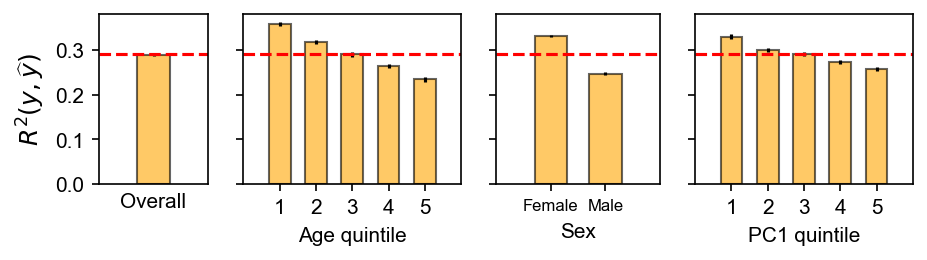

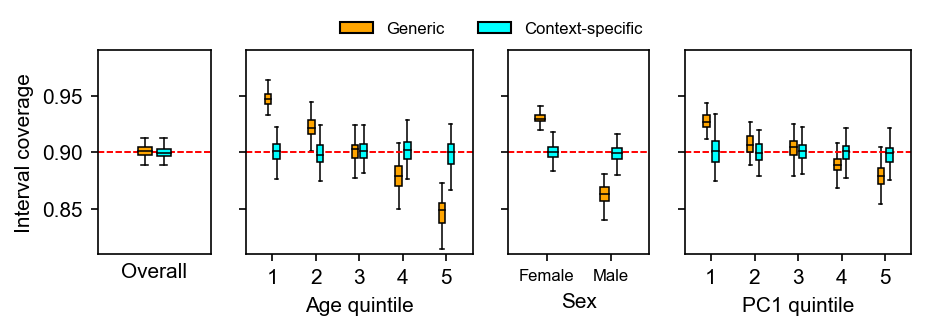

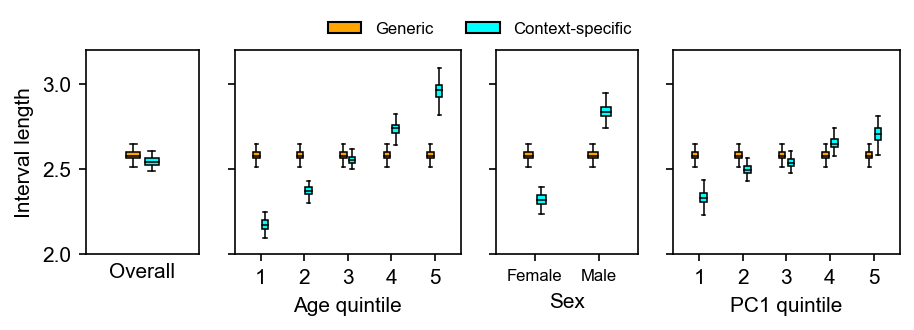

In [4]:
name = "constant_slope.noslope"

df_stats = pd.read_csv(f"cache/{name}.stats.tsv", sep="\t")
fig, axes = plot_r2(df_stats[(df_stats["adjust"] == "none") & (df_stats["n"] == 5000)])
fix_xaxis(axes)
print(f"Number of random seeds: {len(df_stats['seed'].unique())}")

plt.savefig("results/main_r2.pdf", bbox_inches="tight")

fig, axes = multi_group_plot_wrapper(
    df_stats=df_stats.query("n == 5000"),
    groups=["none", "all"],
    colors=["orange", "cyan"],
    labels=["Generic", "Context-specific"],
    val_col="coverage",
    ylim=(0.81, 0.99),
    ylabel="Interval coverage",
    figsize=(7, 1.8),
)
fix_xaxis(axes)
plt.savefig("results/main_coverage.pdf", bbox_inches="tight")

fig, axes = multi_group_plot_wrapper(
    df_stats=df_stats.query("n == 5000"),
    groups=["none", "all"],
    colors=["orange", "cyan"],
    labels=["Generic", "Context-specific"],
    val_col="length",
    ylim=(2, 3.2),
    ylabel="Interval length",
    figsize=(7, 1.8),
)
fix_xaxis(axes)
plt.savefig("results/main_length.pdf", bbox_inches="tight")

# Results for other sample sizes

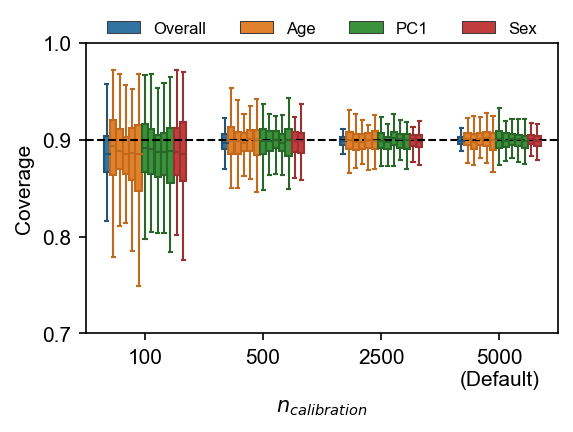

In [5]:
# color palette
palette = dict()
for col in df_stats["col"].unique():
    if col == "marginal":
        palette[col] = "C0"
    elif col.startswith("AGE"):
        palette[col] = "C1"
    elif col.startswith("PC1"):
        palette[col] = "C2"
    elif col.startswith("SEX"):
        palette[col] = "C3"
    else:
        assert False

df_plot = df_stats[df_stats["adjust"] == "all"].drop(columns=["adjust"])

fig, ax = plt.subplots(figsize=(4, 3), dpi=150)

sns.boxplot(
    x="n",
    y="coverage",
    hue="col",
    width=0.7,
    linewidth=1.0,
    fliersize=0,
    palette=palette,
    data=df_plot,
    ax=ax,
)

ax.axhline(y=0.9, color="black", lw=1.0, ls="--")
ax.set_xlabel("$n_{calibration}$")
ax.set_ylabel("Coverage")
labels = [lab.get_text() for lab in ax.get_xticklabels()]
labels[-1] = labels[-1] + "\n(Default)"
ax.set_xticklabels(labels)
lighten_boxplot(ax)
handles, labels = ax.get_legend_handles_labels()

handles = [
    h
    for h, lab in zip(handles, labels)
    if lab in ["marginal", "AGE_q_0", "PC1_q_0", "SEX_q_0"]
]

ax.legend(
    handles=handles,
    labels=[
        "Overall",
        "Age",
        "PC1",
        "Sex",
    ],
    title=None,
    ncol=4,
    loc="center",
    bbox_to_anchor=(0.5, 1.05),
    fontsize=8,
    frameon=False,
)
ax.set_ylim(0.7, 1.0)
plt.tight_layout()

# plt.savefig(f"results/simulation_vary_n.pdf", bbox_inches="tight")

# Unmeasured covariates

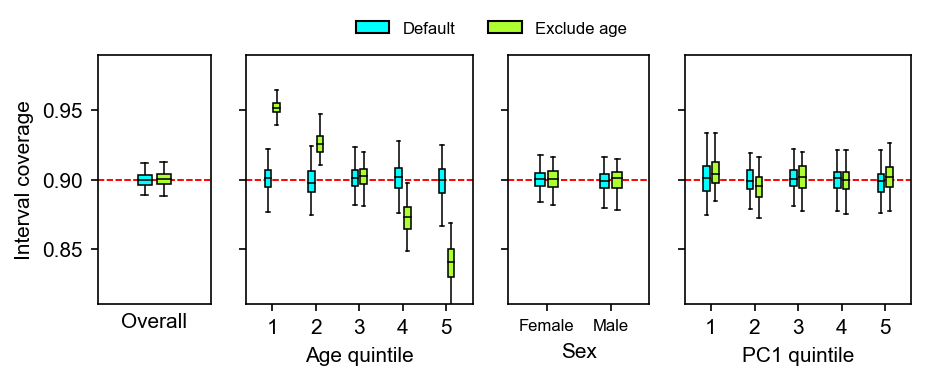

In [6]:
fig, axes = multi_group_plot_wrapper(
    df_stats=df_stats.query("n == 5000"),
    groups=["all", "except-age"],
    colors=["cyan", "greenyellow"],
    labels=["Default", "Exclude age"],
    ylim=(0.81, 0.99),
    ylabel="Interval coverage",
)
fix_xaxis(axes)
plt.savefig(f"results/simulation_unmeasured_cov.pdf", bbox_inches="tight")

# More dummy covariates

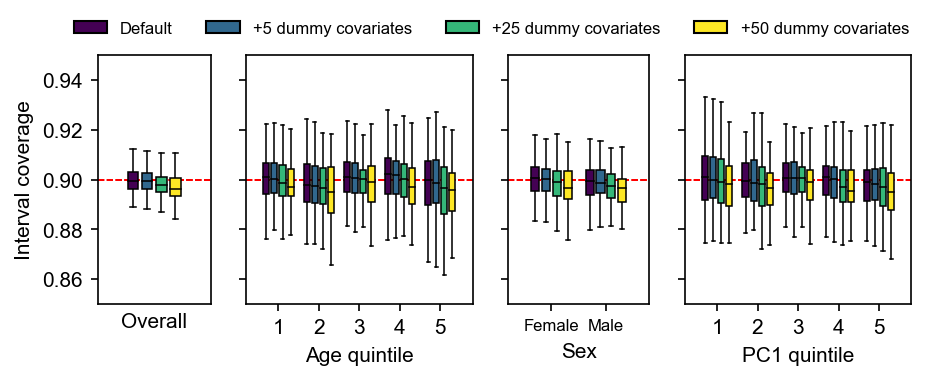

In [7]:
fig, axes = multi_group_plot_wrapper(
    df_stats=df_stats.query("n == 5000"),
    groups=["all", "dummy5", "dummy25", "dummy50"],
    colors=plt.get_cmap("viridis", 4).colors,
    labels=[
        "Default",
        "+5 dummy covariates",
        "+25 dummy covariates",
        "+50 dummy covariates",
    ],
    ylim=(0.85, 0.95),
    ylabel="Interval coverage",
)
fix_xaxis(axes)

plt.savefig(f"results/simulation_excess_dummy.pdf", bbox_inches="tight")